In [29]:
#first, make a dataset using sklearn's make_moons method, with 1000 samples, random_state of 42, and train_test_split the data into 0.8,0.2 split
!nvidia-smi
import torch
from sklearn.datasets import make_moons 
from sklearn.model_selection import train_test_split 

if torch.cuda.is_available():
    device="cuda"
elif torch.backends.mps.is_available():
    device="mps"
else:
    device="cpu"

#now, for the data
num_samples = 1000
noise = 0.07
rand_state = 42

#returns ndarrays
# X is size (num,2), array is size (num,)
X,Y = make_moons(n_samples=num_samples,noise=noise,random_state=rand_state,)
torch.manual_seed(rand_state)



zsh:1: command not found: nvidia-smi


In [30]:
#first, lets turn the tabular data into a dataframe:
import pandas as pd 

df = pd.DataFrame(data={"X_coords": X[:,0], "Y_coords": X[:,1], "Label": Y[:]})
df.head(10)


,X_coords,Y_coords,Label
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0
5,0.599064,-0.289773,1
6,0.290090,-0.204688,1
7,-0.038269,0.459429,1
8,1.613771,-0.293970,1
9,0.693337,0.827819,0


In [31]:
#first, lets convert them to tensors on the cpu
X_data = torch.from_numpy(X).type(torch.float)
Y_labels = torch.from_numpy(Y).type(torch.float)
X_train,X_test,Y_train,Y_test = train_test_split(X_data,Y_labels,test_size=0.2,random_state=rand_state)

for tensor in X_train,X_test,Y_train,Y_test: print(tensor.shape)



torch.Size([800, 2])
torch.Size([200, 2])
torch.Size([800])
torch.Size([200])


Text(0.5, 1.0, 'Testing Data')

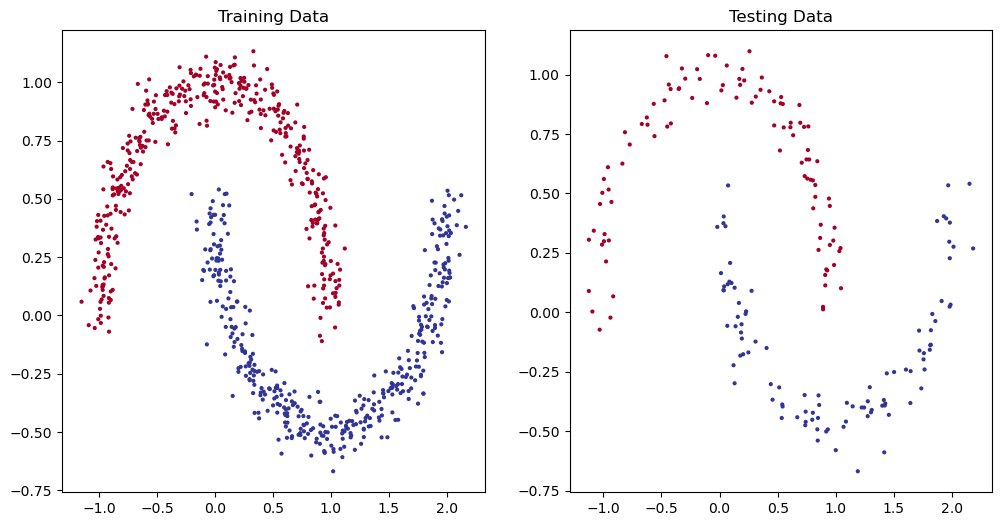

In [32]:
#now, lets graph the data using matplotlib
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(X_train[:,0],X_train[:,1],s=4,c=Y_train,cmap=plt.cm.RdYlBu)
plt.title("Training Data")
plt.subplot(1,2,2)
plt.scatter(X_test[:,0],X_test[:,1],s=4,c=Y_test,cmap=plt.cm.RdYlBu)
plt.title("Testing Data")


In [33]:
#now that we visualized our data, lets make the model: make a nn.Module subclass with non-linear layers capable of fitting the data we used
from torch import nn
class MoonDetectionModel(nn.Module):
    def __init__(self,in_features=2,out_features=1,hidden_neurons=16):
        super().__init__()
        self.sequential_chain = nn.Sequential(
            nn.Linear(in_features=in_features,out_features=hidden_neurons),
            nn.ReLU(),
            nn.Linear(in_features=hidden_neurons,out_features=hidden_neurons),
            nn.ReLU(),
            nn.Linear(in_features=hidden_neurons,out_features=out_features)
            #the other way, if you want custom layers is the nn.Parameter()
            #self.layer_1 = nn.Parameter(torch.randn(size=(1,1)),requires_grad=True)
        )
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.sequential_chain(x)

model_0 = MoonDetectionModel(in_features=2,out_features=1,hidden_neurons=10).to(device)
model_0
        




MoonDetectionModel(
  (sequential_chain): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [34]:
#now, we can define our loss functions and optimizers:
loss_fn = torch.nn.BCEWithLogitsLoss() #REMEMBER, THIS ONE COMES PRE-BUILD WITH A SIGMOID FUNCTION
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [35]:
#Now, we can create the training and testing loop(before, dont forget to set up the data intake using writer and panda dataframes, also import the
# displaying function from github as well as the function for accuracy

#also, try the new bit with the model path: where you can define it as the top, and move with it as needed:
'''
TIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S") #this is to avoid overrides by saving the time

MODEL_PATH = MODEL_DIR / f"{MODEL_NAME}_{TIMESTAMP}.pt"
CSV_PATH = CSV_DIR / f"{MODEL_NAME}_{TIMESTAMP}.csv"
GRAPH_PATH = GRAPH_DIR / f"{MODEL_NAME}_{TIMESTAMP}.png"


csv_path = Path("results/exp1.csv")

# Change the suffix to .png
png_path = csv_path.with_suffix(".png")

can also use with the stem prefix to use just the stem:
base_name = csv_path.stem  # 'exp1'
new_path = Path("graphs") / f"{base_name}.png"

'''

'\nTIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S") #this is to avoid overrides by saving the time\n\nMODEL_PATH = MODEL_DIR / f"{MODEL_NAME}_{TIMESTAMP}.pt"\nCSV_PATH = CSV_DIR / f"{MODEL_NAME}_{TIMESTAMP}.csv"\nGRAPH_PATH = GRAPH_DIR / f"{MODEL_NAME}_{TIMESTAMP}.png"\n\n\ncsv_path = Path("results/exp1.csv")\n\n# Change the suffix to .png\npng_path = csv_path.with_suffix(".png")\n\ncan also use with the stem prefix to use just the stem:\nbase_name = csv_path.stem  # \'exp1\'\nnew_path = Path("graphs") / f"{base_name}.png"\n\n'

In [36]:
#first, lets import the plot_descision_boundary function and run it on an current model inference (just to see how it behaves)
from pathlib import Path 
import requests 

if Path("helper_functions.py").is_file():
    print(f"helper_function.py file already exists. Skipping download...")
else:
    print(f"Downloading helper_function.py from the web...")
    request = requests.get(url="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    #the response object is an object that stores the data housed at the request place given
    #now, lets write it locally:
    with open(file="helper_function.py",mode="wb",newline="") as file:
        file.write(request.content)


helper_function.py file already exists. Skipping download...


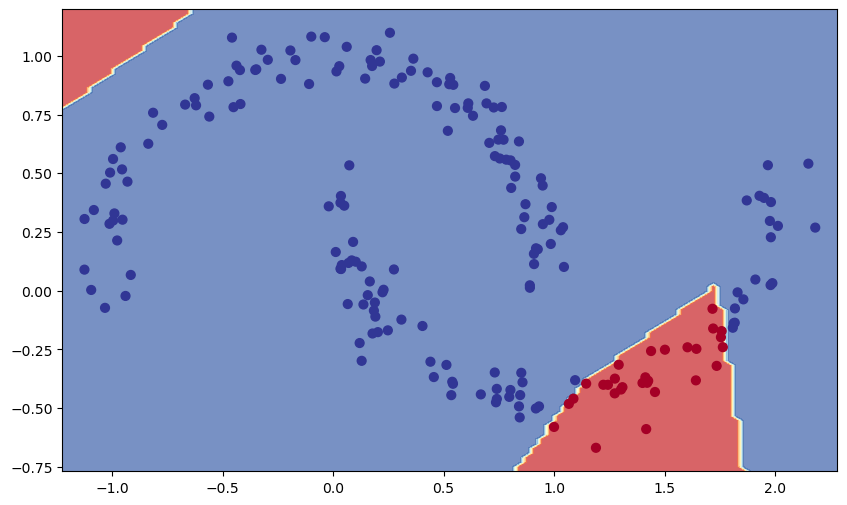

In [37]:
#now, lets do an initial inference on the logits that the model outputs and see the results:
from helper_functions import accuracy_fn
from helper_functions import plot_decision_boundary 

#dont forget to move the data so that the model and data are on the save device

model_0.eval()
with torch.inference_mode():
    initial_logit_test_preds = model_0(X_test.to(device)) #returns a type (200,1) of type logits, but the expected form is of type (200,1)

initial_test_preds = torch.round(torch.sigmoid(initial_logit_test_preds)).squeeze()

#now lets display them in the graph:
plt.figure(figsize=(10,6))
plot_decision_boundary(model=model_0,X=X_test,y=initial_test_preds)



In [38]:
""" 
from pathlib import Path
from datetime import datetime

# === Configuration: Set this at the top of your script ===
model_name = "model_0"
experiment_name = "exp1"

# Optional: add timestamp to prevent overwrite
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# === Base folder where everything will be stored ===
base_dir = Path("experiments") / f"{model_name}_{experiment_name}"
model_dir = base_dir / "models"
csv_dir = base_dir / "csv"
graph_dir = base_dir / "graphs"

# === Create directories (recursively if needed) ===
for directory in [model_dir, csv_dir, graph_dir]:
    directory.mkdir(parents=True, exist_ok=True)

# === Define file paths ===
model_path = model_dir / f"{model_name}_{experiment_name}_{timestamp}.pt"
csv_path = csv_dir / f"{model_name}_{experiment_name}_{timestamp}.csv"
loss_graph_path = graph_dir / f"{model_name}_{experiment_name}_loss_{timestamp}.png"
accuracy_graph_path = graph_dir / f"{model_name}_{experiment_name}_accuracy_{timestamp}.png"

# === Example usage ===
print("Model will be saved to:", model_path)
print("CSV will be saved to:", csv_path)
print("Loss graph will be saved to:", loss_graph_path)
print("Accuracy graph will be saved to:", accuracy_graph_path)

"""

' \nfrom pathlib import Path\nfrom datetime import datetime\n\n# === Configuration: Set this at the top of your script ===\nmodel_name = "model_0"\nexperiment_name = "exp1"\n\n# Optional: add timestamp to prevent overwrite\ntimestamp = datetime.now().strftime("%Y%m%d-%H%M%S")\n\n# === Base folder where everything will be stored ===\nbase_dir = Path("experiments") / f"{model_name}_{experiment_name}"\nmodel_dir = base_dir / "models"\ncsv_dir = base_dir / "csv"\ngraph_dir = base_dir / "graphs"\n\n# === Create directories (recursively if needed) ===\nfor directory in [model_dir, csv_dir, graph_dir]:\n    directory.mkdir(parents=True, exist_ok=True)\n\n# === Define file paths ===\nmodel_path = model_dir / f"{model_name}_{experiment_name}_{timestamp}.pt"\ncsv_path = csv_dir / f"{model_name}_{experiment_name}_{timestamp}.csv"\nloss_graph_path = graph_dir / f"{model_name}_{experiment_name}_loss_{timestamp}.png"\naccuracy_graph_path = graph_dir / f"{model_name}_{experiment_name}_accuracy_{times

In [39]:
#next, lets get the paths in order: create a new folder that goes by the experiment name, with subfolders for models, results.csv, and results.pngs or image
#graphs
#from there prepare the writer by getting the paths in order

'''
# Change the suffix to .png
png_path = csv_path.with_suffix(".png")

can also use with the stem prefix to use just the stem:
base_name = csv_path.stem  # 'exp1'
new_path = Path("graphs") / f"{base_name}.png"
'''

#STRUCTURE: base dir is the model name (stays the same), then, inside that folder is the folder with the experiments (by name)
#then each experiment has a folder containing the model, results, and graphs, with the only variance being the timestamp

from pathlib import Path 
from datetime import datetime 

MODEL_NAME = "model_0"
EXPERIMENT_NAME = "exp1"

#now that you have the base model name and experiment name, we can create a timestamp so that temporal data is saved as well:
now = datetime.now()
#returns a datetime object of form datetime.datetime(2025, 6, 25, 16, 42, 17, 382991)
TIMESTAMP = f"{now.month}-{now.day}-{str(now.year)[-2:]}-{now.strftime('%I-%M-%S%p')}"
#creates a formatted string called TIMESTAMP, now.month returns integer for the month
#the[-2:] will cut off the first 2 elements of the string
#remember: indexing works like 2,1,0,-1,-2 ... where -1 means the last element in the string and -2 is the second to last element in the string
#I is just hour in 12 hour form


#the resulting format is of type: 6/25/25-04:25:30 PM


#now, we can start making the directory tree:
BASE_DIR = Path(f"{MODEL_NAME}")
EXPERIMENT_DIR = BASE_DIR / f"{EXPERIMENT_NAME}"

MODEL_DIR = EXPERIMENT_DIR / "models"
RESULTS_DIR = EXPERIMENT_DIR / "results"
GRAPHS_DIR = EXPERIMENT_DIR / "graphs"

#create directories (NOTE: PARENTS=TRUE, MEANS CREATING TEH RESULTS AND GRAPHS DIR WILL ALSO CREATE BASE AND EXPERIMENT, SO DO NOT HAVE TO EXPLICITLY CREATE)
for directory in [BASE_DIR,EXPERIMENT_DIR,MODEL_DIR,RESULTS_DIR,GRAPHS_DIR]:
    directory.mkdir(parents=True,exist_ok=True)

#define the file paths:
MODEL_PATH = MODEL_DIR / f"{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}.pt"
RESULTS_PATH = RESULTS_DIR / f"{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}.csv"
LOSS_GRAPH_PATH = GRAPHS_DIR / f"{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}_loss.png"
ACCURACY_GRAPH_PATH = GRAPHS_DIR / f"{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}_accuracy.png"


In [40]:
""" 
from torchmetrics.classification import Accuracy
import torch

class MetricsTracker:
    def __init__(self, num_classes, task="multiclass", device="cpu"):
        self.train_accuracy = Accuracy(task=task, num_classes=num_classes).to(device)
        self.test_accuracy = Accuracy(task=task, num_classes=num_classes).to(device)

    def update(self, preds, targets, phase):
        if phase == 'train':
            self.train_accuracy.update(preds, targets)
        elif phase == 'test':
            self.test_accuracy.update(preds, targets)
        else:
            raise ValueError("Phase must be 'train' or 'test'.")

    def compute(self):
        return {
            'train_accuracy': self.train_accuracy.compute().item(),
            'test_accuracy': self.test_accuracy.compute().item()
        }

    def reset(self):
        self.train_accuracy.reset()
        self.test_accuracy.reset()

"""

' \nfrom torchmetrics.classification import Accuracy\nimport torch\n\nclass MetricsTracker:\n    def __init__(self, num_classes, task="multiclass", device="cpu"):\n        self.train_accuracy = Accuracy(task=task, num_classes=num_classes).to(device)\n        self.test_accuracy = Accuracy(task=task, num_classes=num_classes).to(device)\n\n    def update(self, preds, targets, phase):\n        if phase == \'train\':\n            self.train_accuracy.update(preds, targets)\n        elif phase == \'test\':\n            self.test_accuracy.update(preds, targets)\n        else:\n            raise ValueError("Phase must be \'train\' or \'test\'.")\n\n    def compute(self):\n        return {\n            \'train_accuracy\': self.train_accuracy.compute().item(),\n            \'test_accuracy\': self.test_accuracy.compute().item()\n        }\n\n    def reset(self):\n        self.train_accuracy.reset()\n        self.test_accuracy.reset()\n\n'

In [41]:
#now, the train/test loop: use torchmetrics accuracy function, train untill 96 percent accuracy, print every 10 epochs
import csv 
import torchmetrics
from torchmetrics.classification import Accuracy

#HOW TO GUIDE WITH TORCHMETRICS:
# using torchmetrics.classification import Accuracy, 
#it has 3 main methods: Accuracy.update(preds, targets), which is used every batch to update an ever expanding list inside of the accuracy object
#Accuracy.compute() computes and stores the accuracy for all of the preds and targets it contain
#Accuracy.item():.4f will return the object as a 4 decimal place float
#Accuracy.reset(), which is done at the start of every epoch resets it

#NOTE: FOR LARGER PROJECTS, YOU CAN WRAP THE DIFFERENT METRICS INTO A LARGER CLASS, BUT THAT IS TOO MUCH WORK FOR ONLY 2 METRICS


#first, move the data to device:
X_train,X_test,Y_train,Y_test = (tensor.to(device) for tensor in (X_train,X_test,Y_train,Y_test))

#next, get the variables ready:
epochs = 1000
model_0=model_0.to(device)

#now, get the writer set up:

with open(file=RESULTS_PATH,mode="w",newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch","Training Loss","Testing Loss","Training Accuracy","Testing Accuracy"])
    #ERROR LOG: if you use a curly brace, with now key-value pairs it assumes you are making a set, not a list or a dict

    #lets first define the Accuracy object:
    training_acc = Accuracy(task="binary",num_classes=2).to(device) #REMEMBER EVERYTHING STARTS ON CPU
    testing_acc = Accuracy(task="binary",num_classes=2).to(device)

    for epoch in range(epochs):

        #first, do a forward pass on the data
        model_0.train()
        Y_logit_preds = model_0(X_train).squeeze()
        Y_preds = torch.round(torch.sigmoid(Y_logit_preds))
        
        #now, calculate the loss and accuracy, making sure to use the torchmetrics one
        loss = loss_fn(Y_logit_preds,Y_train)
        training_acc.reset() #reset what was stored for the last epoch
        training_acc.update(Y_preds,Y_train) #update it with the current epoch

        #now, zero the gradients to prepare for backprop
        optimizer.zero_grad()

        #now, preform a backwards pass on the data
        loss.backward()

        #now, step the optimizer in the direction to lower the loss function:
        optimizer.step()

        #now the testing loop
        model_0.eval()
        with torch.inference_mode():
            #forward pass on the data:
            Y_test_logit_preds = model_0(X_test).squeeze()
            Y_test_preds = torch.round(torch.sigmoid(Y_test_logit_preds))

            #now calculate the loss function and accuracy
            testing_loss = loss_fn(Y_test_preds,Y_test)
            testing_acc.reset()
            testing_acc.update(Y_test_preds,Y_test)

            #now, lets write the data we obtained into the csv file we defined earlier up in the file:
            training_loss_write = loss.detach().cpu().numpy()
            testing_loss_write = testing_loss.detach().cpu().numpy()
            training_acc_write = training_acc.compute().item()
            testing_acc_write = testing_acc.compute().item()


            writer.writerow([epoch,training_loss_write,testing_loss_write,training_acc_write,testing_acc_write])

            #now lets print every 10 rows
            if epoch % 10 == 0:
                print(f"Epoch: {epoch} | Training Loss: {training_loss_write} | Testing Loss: {testing_loss_write} | Training Accuracy: {training_acc_write} | Testing Accuracy: {testing_acc_write}")



Epoch: 0 | Training Loss: 0.6953220963478088 | Testing Loss: 0.8151611089706421 | Training Accuracy: 0.3737500011920929 | Testing Accuracy: 0.4950000047683716
Epoch: 10 | Training Loss: 0.6820831894874573 | Testing Loss: 0.6706352829933167 | Training Accuracy: 0.7599999904632568 | Testing Accuracy: 0.7300000190734863
Epoch: 20 | Training Loss: 0.6679846048355103 | Testing Loss: 0.6429255604743958 | Training Accuracy: 0.7887499928474426 | Testing Accuracy: 0.7649999856948853
Epoch: 30 | Training Loss: 0.6509571075439453 | Testing Loss: 0.6478135585784912 | Training Accuracy: 0.7774999737739563 | Testing Accuracy: 0.7300000190734863
Epoch: 40 | Training Loss: 0.6265826225280762 | Testing Loss: 0.659405529499054 | Training Accuracy: 0.7599999904632568 | Testing Accuracy: 0.6899999976158142
Epoch: 50 | Training Loss: 0.5939171314239502 | Testing Loss: 0.6532044410705566 | Training Accuracy: 0.7524999976158142 | Testing Accuracy: 0.699999988079071
Epoch: 60 | Training Loss: 0.55373495817184

In [42]:
#The model is now trained! now, we can do an inference test on it and save the model's state dict and images
#first, lets test the model:
import pandas as pd
df = pd.read_csv(filepath_or_buffer=RESULTS_PATH) #now, we have a dataframe containing the data

plt.figure(figsize=(10,6))
plt.plot(df["Epoch"],df["Training Loss"],label="Training Loss")
plt.plot(df["Epoch"],df["Testing Loss"],label="Testing Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Function Values")
plt.legend(prop={"size": 14})
plt.savefig(LOSS_GRAPH_PATH)
plt.close()

plt.plot(df["Epoch"],df["Training Accuracy"],label="Training Accuracy")
plt.plot(df["Epoch"],df["Testing Accuracy"],label="Testing Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy Function Values")
plt.legend(prop={"size": 14})
plt.savefig(ACCURACY_GRAPH_PATH)
plt.close() #SAVEFIG DOES NOT AUTOMATICALLY CLOSE THE PLOT







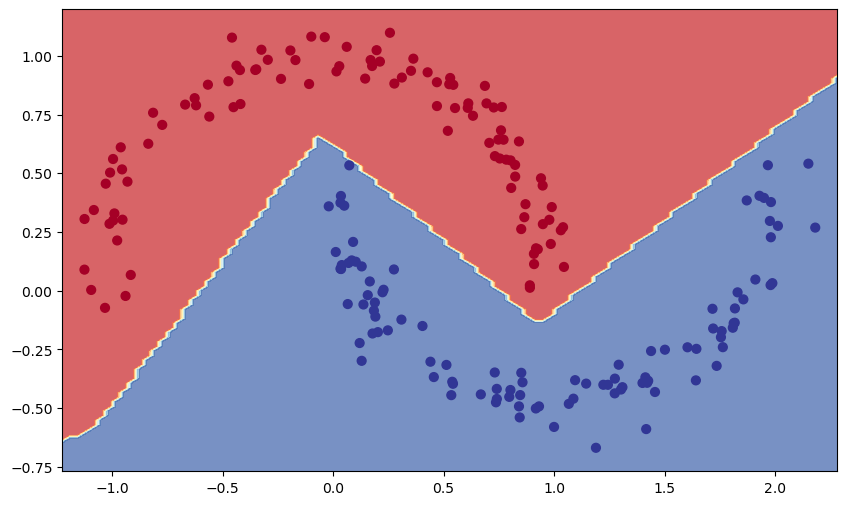

In [43]:
#lets try to display the models predictions just to see how good/bad they are:

model_0.eval()
with torch.inference_mode():
    Y_final_logit_preds = model_0(X_test).squeeze()
    Y_final_preds = torch.round(torch.sigmoid(Y_final_logit_preds))


plt.figure(figsize=(10,6))
plot_decision_boundary(model=model_0,X=X_test,y=Y_final_preds)

In [44]:
#Now, just redo everything you just did, but for a multi-class project with spirals
#1: make the dataset
#2: if tabular, turn into a dataframe
#3: turn the dataset into tensors
#4: then, graph the data
#4.5: actually make and move the model
#5: first, do an inference in the dark to see how it looks
#6: then get the filestorage in order
#7: then, use the requests to import from a file across the web
#8: set up the train-test loop using writers and torchmetric objects
#9: take the date from the csv, read it, and plot
#10: look at the results of the data by ploting descision boundaries
#11: save the model

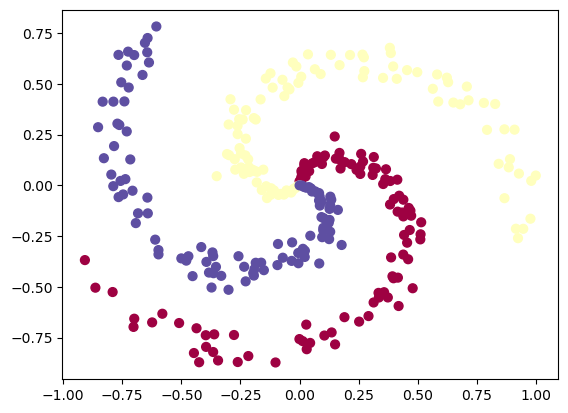

In [25]:
import torch
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

torch.manual_seed(42)




# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()



In [26]:
#now, lets turn the data into a dataframe:
import pandas as pd 

df = pd.DataFrame(data={"X1": X[:,0], "X2": X[:,1], "Y": y[:]})

df.tail(30)

,X1,X2,Y
270,-0.706576,-0.026453,2
271,-0.692604,-0.186104,2
272,-0.715971,0.127716,2
273,-0.736738,0.030610,2
274,-0.746133,-0.044767,2
275,-0.757263,0.021773,2
276,-0.765486,-0.057951,2
277,-0.730975,0.265732,2
278,-0.787869,-0.003996,2
279,-0.796208,0.053148,2


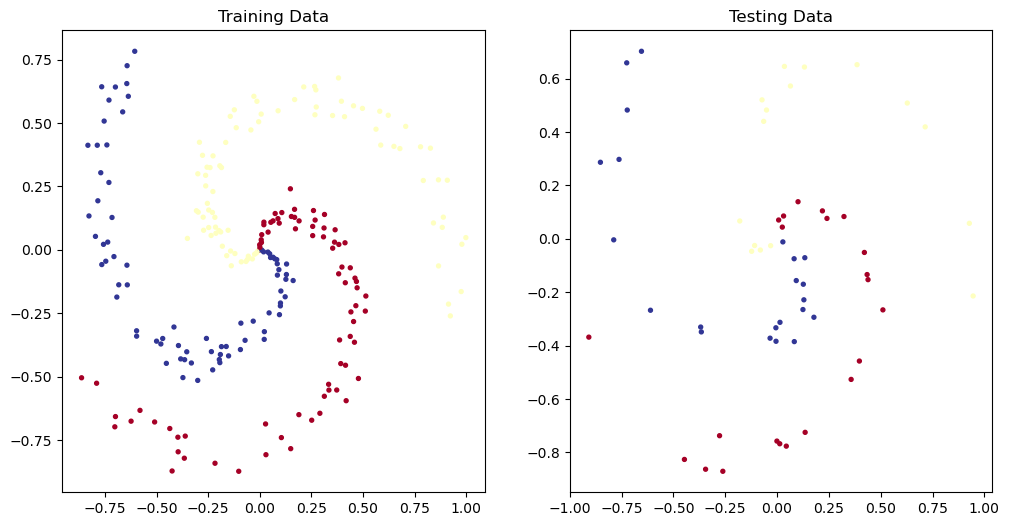

In [27]:
#first, move the data into tensors and then graph the resulting data:
from sklearn.model_selection import train_test_split 

X_data = torch.from_numpy(X).type(torch.float)
Y_labels = torch.from_numpy(y).type(torch.float)

X_train,X_test,Y_train,Y_test = train_test_split(X_data,Y_labels, test_size=0.2,random_state=42)

#now, lets plot the data:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(X_train[:,0], X_train[:,1], s=8, c=Y_train, cmap=plt.cm.RdYlBu)
plt.title("Training Data")

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], X_test[:,1], s=8, c=Y_test, cmap=plt.cm.RdYlBu)
plt.title("Testing Data")
plt.show()


In [28]:
#Now, we shall make the model!!!
#Note: it will return of type (batch,num_classes=3)
from torch import nn
class SwirlModel(nn.Module):
    def __init__(self,in_features=D,out_features=K,hidden_neurons=8):
        super().__init__()
        self.sequential_run = nn.Sequential(
            nn.Linear(in_features=in_features,out_features=hidden_neurons),
            nn.ReLU(),
            nn.Linear(in_features=hidden_neurons, out_features=hidden_neurons),
            nn.ReLU(),
            nn.Linear(in_features=hidden_neurons, out_features=hidden_neurons),
            nn.ReLU(),
            nn.Linear(in_features=hidden_neurons, out_features=out_features)
        )
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.sequential_run(x)
model_1 = SwirlModel(hidden_neurons=16).to(device)
model_1

SwirlModel(
  (sequential_run): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [29]:
#LOSS FUNCTION AND OPTIMIZER:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [30]:
#write the code for again importing the plot_descision_boundary
from pathlib import Path 
import requests 

if Path("helper_functions.py").is_file():
    print(f"Allready downloaded")
else: 
    request = requests.get(url="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open(file="helper_functions.py",mode="wb",newline="") as file:
        file.write(request.content)
from helper_functions import plot_decision_boundary

Allready downloaded


tensor([2, 2, 2, 2, 2], device='mps:0')


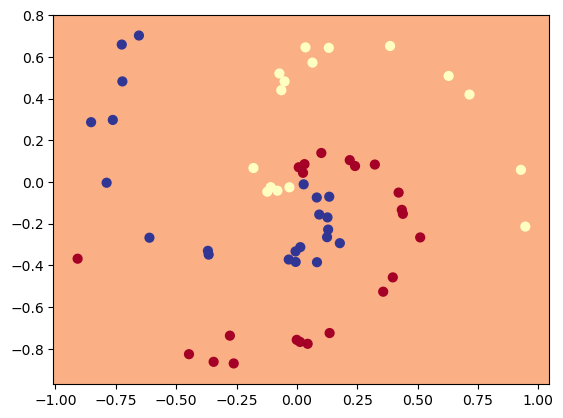

In [31]:
#Now, let us get a raw prediction and plot using plot_boundary

model_1.eval()
with torch.inference_mode():
    Y_initial_logit_preds = model_1(X_test.to(device)).squeeze()
    Y_initial_preds = torch.softmax(input=Y_initial_logit_preds,dim=1).argmax(dim=1)
    print(f"{Y_initial_preds[:5]}")
    plot_decision_boundary(model=model_1,X=X_test.to(device),y=Y_test)

In [32]:
#Now, it is time to create the filesystem for storing the data
from pathlib import Path 
from datetime import datetime 

#base things make
MODEL_NAME = "model_1"
EXPERIMENT_NAME = "exp1"

#LETS ALSO CREATE THE TIMESTAMP
now = datetime.now()
TIMESTAMP = f"{now.month}-{now.day}-{str(now.year)[-2:]}-{now.strftime("%I-%M-%S%p")}"

#Now, lets start making the directories
BASE_DIR = Path(f"{MODEL_NAME}")
EXPERIMENT_DIR = BASE_DIR / f"{EXPERIMENT_NAME}"
MODEL_DIR = EXPERIMENT_DIR / "models"
RESULTS_DIR = EXPERIMENT_DIR / "results"
GRAPHS_DIR = EXPERIMENT_DIR / "graphs"
LOSS_GRAPH_DIR = GRAPHS_DIR / "loss"
ACCURACY_GRAPH_DIR = GRAPHS_DIR / "accuracy"

#NOW, LETS RECURSIVELY MAKE THE DIRECTORY SYSTEM:
for directory in [MODEL_DIR,RESULTS_DIR,GRAPHS_DIR,LOSS_GRAPH_DIR,ACCURACY_GRAPH_DIR]: directory.mkdir(parents=True,exist_ok=True)

#now, lets create the file paths, where we can save the things
MODEL_PATH = MODEL_DIR / f"{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}"
RESULTS_PATH = RESULTS_DIR / f"{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}.csv"
LOSS_GRAPH_PATH = LOSS_GRAPH_DIR / f"{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}_loss.png"
ACCURACY_GRAPH_PATH = ACCURACY_GRAPH_DIR / f"{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}_accuracy.png"




In [33]:
#NOW, LETS GET THE TRAIN/TEST LOOP GOING:
from torchmetrics.classification import Accuracy
import csv

#first, move the data to the GPU:
X_train,X_test,Y_train,Y_test = (tensor.to(device) for tensor in [X_train,X_test,Y_train,Y_test])

#for some reason, you have to move the model again?
model_1 = model_1.to(device)

#then, get the variables ready(meaning both the writer and the torchmetrics Accuracy object):
epochs = 1000 

with open(file=RESULTS_PATH,mode="w",newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epochs","Training Loss", "Testing Loss", "Training Accuracy", "Testing Accuracy"])
    #testing objects initialized:
    #ERROR LOG: THE ACCURACY OBJECTS MUST ALSO BE ON THE DEVICE
    training_accuracy = Accuracy(task="multiclass",num_classes=3).to(device)
    testing_accuracy = Accuracy(task="multiclass",num_classes=3).to(device)

    for epoch in range(epochs):
        
        #forward pass:
        model_1.train()
        Y_logit_preds = model_1(X_train).squeeze()
        Y_preds = torch.softmax(input=Y_logit_preds,dim=1).argmax(dim=1)

        #reset both accuracy variables
        training_accuracy.reset()
        testing_accuracy.reset()

        #now, calculate the loss per batch (1 batch per epoch, just so happens)
        #ERROR LOG: TARGET is what the model was expecting, INPUT WAS WHAT YOU GAVE IT
        loss = loss_fn(Y_logit_preds,Y_train)
        training_accuracy.update(Y_preds,Y_train)

        #now, zero the gradients in preparation for backprop
        optimizer.zero_grad()

        #now, do a backwards pass through the data
        loss.backward()

        #now, step the optimizer
        optimizer.step()
        
        #now, we can start the testing loop:

        model_1.eval()
        with torch.inference_mode():
            #forward pass
            Y_test_logit_preds = model_1(X_test).squeeze()
            Y_test_preds = torch.softmax(input=Y_test_logit_preds,dim=1).argmax(dim=1)

            #calculate loss and update accuracy:
            testing_loss = loss_fn(Y_test_logit_preds,Y_test) #ERROR LOG: remember, the LOSS FUNCITON TAKES LOGITS NOT PREDS
            testing_accuracy.update(Y_test_preds,Y_test)

        #now, lets prepare for the write:
        training_loss_write = loss.detach().cpu().numpy()
        testing_loss_write = testing_loss.detach().cpu().numpy()
        training_accuracy_write = training_accuracy.compute().item()
        testing_accuracy_write = testing_accuracy.compute().item()

        #now, the write:
        writer.writerow([epoch,training_loss_write,testing_loss_write,training_accuracy_write,testing_accuracy_write])

        #now the print:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Training Loss: {training_loss_write} | Testing Loss: {testing_loss_write} | Training Accuracy: {training_accuracy_write} | Testing Accuracy: {testing_accuracy_write}")



        







Epoch: 0 | Training Loss: 1.111961841583252 | Testing Loss: 1.0823588371276855 | Training Accuracy: 0.32499998807907104 | Testing Accuracy: 0.36666667461395264
Epoch: 10 | Training Loss: 1.091374158859253 | Testing Loss: 1.0791232585906982 | Training Accuracy: 0.40416666865348816 | Testing Accuracy: 0.46666666865348816
Epoch: 20 | Training Loss: 1.080054759979248 | Testing Loss: 1.078298568725586 | Training Accuracy: 0.48750001192092896 | Testing Accuracy: 0.5
Epoch: 30 | Training Loss: 1.070525050163269 | Testing Loss: 1.0754116773605347 | Training Accuracy: 0.5249999761581421 | Testing Accuracy: 0.46666666865348816
Epoch: 40 | Training Loss: 1.0605442523956299 | Testing Loss: 1.0695242881774902 | Training Accuracy: 0.4625000059604645 | Testing Accuracy: 0.4166666567325592
Epoch: 50 | Training Loss: 1.0474019050598145 | Testing Loss: 1.0599638223648071 | Training Accuracy: 0.49166667461395264 | Testing Accuracy: 0.4333333373069763
Epoch: 60 | Training Loss: 1.0291839838027954 | Testin

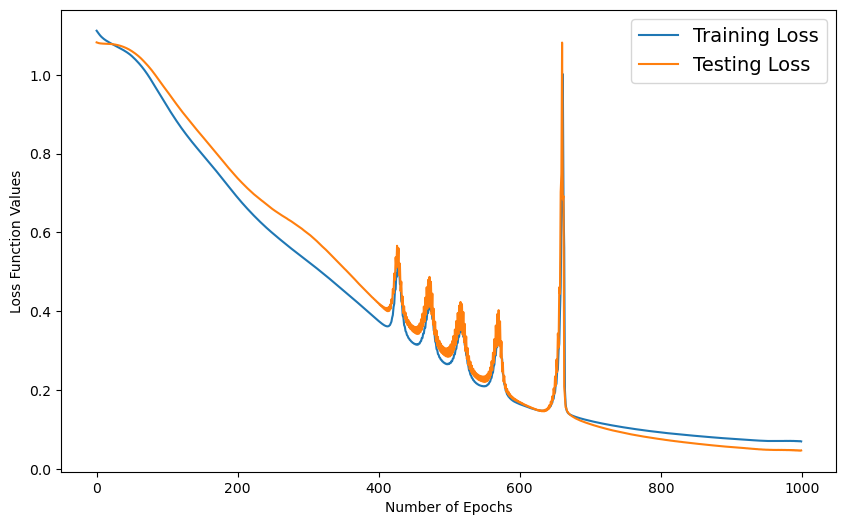

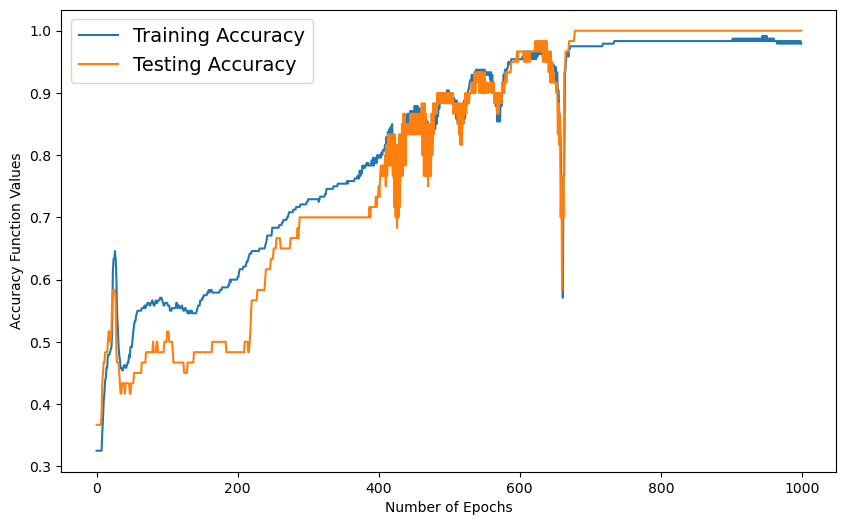

In [34]:
#now, that the csv file was created, lets: 1 create and save the graphs of the train test data. 
import pandas as pd

df = pd.read_csv(filepath_or_buffer=RESULTS_PATH)

#now, the plotting
plt.figure(figsize=(10,6))
plt.plot(df["Epochs"],df["Training Loss"],label="Training Loss")
plt.plot(df["Epochs"],df["Testing Loss"],label="Testing Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Function Values")
plt.legend(prop={"size": 14})
plt.savefig(LOSS_GRAPH_PATH)
plt.show()
plt.close()

plt.figure(figsize=(10,6))
plt.plot(df["Epochs"],df["Training Accuracy"],label="Training Accuracy")
plt.plot(df["Epochs"],df["Testing Accuracy"],label="Testing Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy Function Values")
plt.legend(prop={"size": 14})
plt.savefig(ACCURACY_GRAPH_PATH)
plt.show()
plt.close()





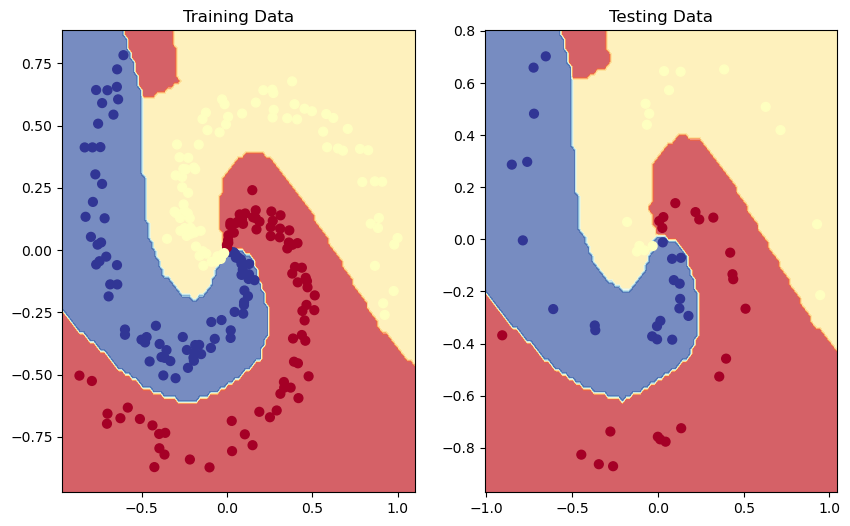

In [35]:
#now, lets use plot_descision_boundary to see how the model is doing

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plot_decision_boundary(model=model_1,X=X_train,y=Y_train)
plt.title("Training Data")
plt.subplot(1,2,2)
plot_decision_boundary(model=model_1,X=X_test,y=Y_test)
plt.title("Testing Data")
plt.show()

In [36]:
#Now that we got results we are happy with, lets try saving the model:

torch.save(obj=model_1.state_dict(),f=MODEL_PATH)

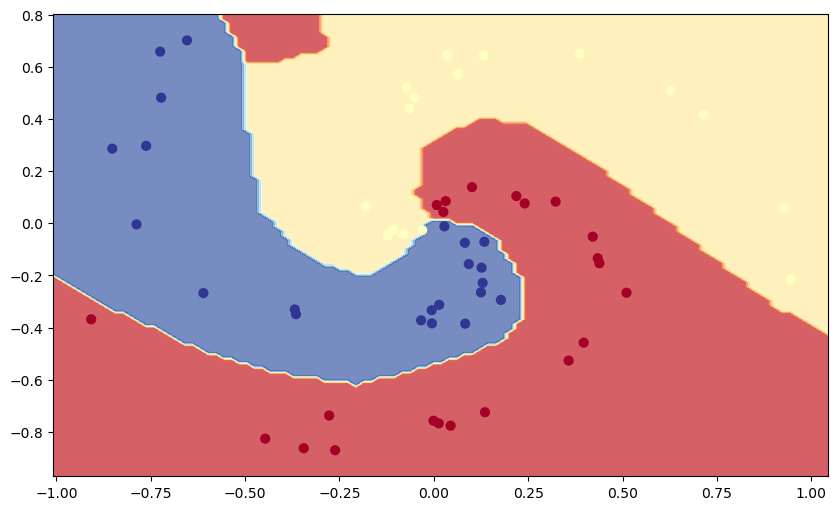

In [38]:
#we can now try loading the model and seeing how it preforms:

model_1_loaded = SwirlModel(hidden_neurons=16).to(device)
model_1_loaded.load_state_dict(torch.load(f=MODEL_PATH,weights_only=True))

#now lets infer on it, specifically by plotting
model_1_loaded.eval()
with torch.inference_mode():
    plt.figure(figsize=(10,6))
    plot_decision_boundary(model=model_1_loaded,X=X_test,y=Y_test)



